<a href="https://colab.research.google.com/github/Viroslav/DLS/blob/main/%5Bhw%5Dsemantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>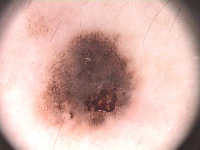</td><td>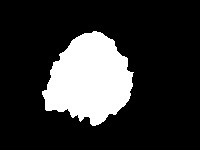</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unrar x "/content/drive/MyDrive/PH2Dataset.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/PH2Dataset.rar


Would you like to replace the existing file PH2Dataset/PH2_dataset.txt
 36280 bytes, modified on 2013-07-11 14:07
with a new one
 36280 bytes, modified on 2013-07-11 14:07

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit N


Would you like to replace the existing file PH2Dataset/PH2_dataset.xlsx
 26731 bytes, modified on 2013-07-11 14:09
with a new one
 26731 bytes, modified on 2013-07-11 14:09

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [ ]:
!ls

drive  PH2Dataset  sample_data


In [ ]:
!gdown --id 1N_EbiemTQuCNxN_vPN_YviHK0LWLfwkD

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1N_EbiemTQuCNxN_vPN_YviHK0LWLfwkD 



In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

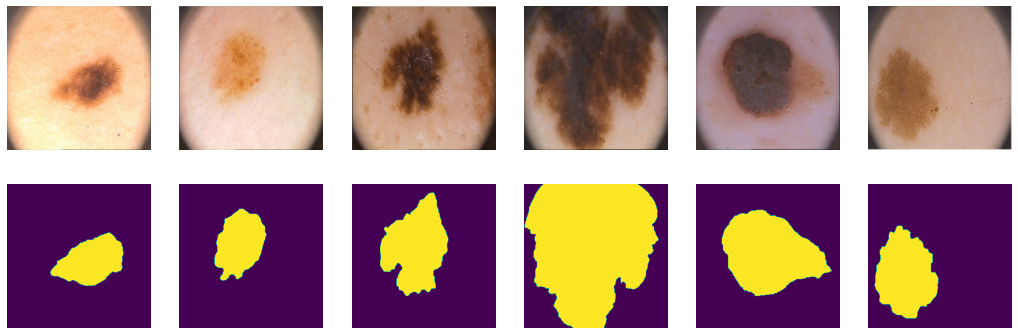

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 12
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Для отчёта
import pandas as pd

results_report = []

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

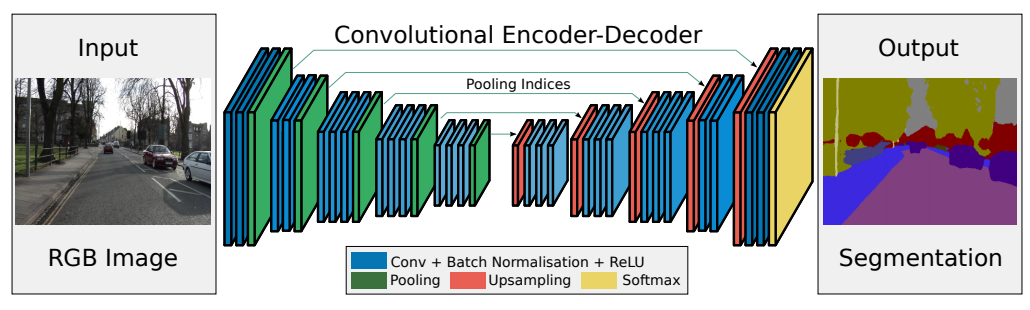

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        
        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            )
        self.pool0 = nn.MaxPool2d(2, stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            )
        self.pool1 = nn.MaxPool2d(2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            )
        self.pool2 = nn.MaxPool2d(2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            )
        self.pool3 = nn.MaxPool2d(2, stride=2, return_indices=True) # 32 -> 16


        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.pool4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        
        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            )

        self.upsample1 = nn.MaxUnpool2d(2, stride=2) # 16 -> 32
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2) # 64 -> 128
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            )
        self.upsample4 = nn.MaxUnpool2d(2, stride=2) # 128 -> 256
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1),
            )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        e4, ind4 = self.pool4(self.enc_conv4(e3))
        
        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, ind4))
        d1 = self.dec_conv1(self.upsample1(d0, ind3))
        d2 = self.dec_conv2(self.upsample2(d1, ind2))
        d3 = self.dec_conv3(self.upsample3(d2, ind1))
        d4 = self.dec_conv4(self.upsample4(d3, ind0))  # no activation - на выходе логиты
        return d4

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), min=0, max=10).ceil() / 10  # This is equal to comparing with thresholds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch    
    # L = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

    # # version from tf: L = max(x, 0) - x * z + log(1 + exp(-abs(x)))
    L = F.relu(y_pred) - y_real * y_pred + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    return L.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    train_loss_history, val_loss_history = [], []

    time_start = time()

    for epoch in range(epochs):
        
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)

        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.cuda()).detach().cpu() # detach and put into cpu


        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(21,7))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_val[k, 0].numpy(), cmap='gray')
            plt.title('Ground truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        # для графика train/val loss
        avg_loss_val = 0
        with torch.no_grad():
            for x_val_batch, y_val_batch in data_val:
                # make prediction
                x_val_batch = x_val_batch.to(device)
                y_val_batch = y_val_batch.to(device)
                y_val_pred = model(x_val_batch)

                # calculate loss
                loss_val = loss_fn(y_val_batch, y_val_pred)
                
                # log per-batch train metrics   
                avg_loss_val += loss_val.item() / len(data_val)

        val_loss_history.append(avg_loss_val)
        train_loss_history.append(avg_loss)


        plt.figure()
        plt.plot(train_loss_history, label="train_loss")
        plt.plot(val_loss_history, label="val_loss")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.title(f'Train and validation loss')
        plt.show()
    
    time_end = time()
    training_time = (time_end - time_start) / 60
    return training_time



## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        # получим логиты
        Y_pred = model(X_batch.to(device))
        # переведём их в вероятности
        Y_pred = torch.sigmoid(Y_pred)
        # с помощью threshold переведём вероятности в предсказанные лейблы 0 или 1
        Y_pred = 1 * (Y_pred > threshold) #<TODO>
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

In [ ]:
## Новая функция для определения оптимального порога в score_model()
def plot_thresholds(model, iou_pytorch, data_val):
    NUM = 51 # количество значений для thresholds от 0 до 1
    
    metric_values = np.zeros(NUM)
    thresholds = np.linspace(0, 1, num=NUM)
    
    value_max, threshold_max = 0, 0
    for i, threshold in enumerate(thresholds):
        metric_values[i] = score_model(model, iou_pytorch, data_val, threshold=threshold)
        
        if metric_values[i] > value_max:
            threshold_max = threshold
            value_max = metric_values[i]
        
    plt.plot(thresholds, metric_values)
    plt.xlabel("Thresholds")
    plt.ylabel("Metric value")
    plt.title(f'Threshold ({threshold_max:.6}) for maximal value of metric on validation ({value_max:.6})')
    plt.show()
    
    return threshold_max, value_max

In [ ]:
## Новая функция для вычисления inference time
def calc_inference_time(model, device='cuda', input_shape=(256, 256), num_iters=100):
    if device == 'cuda':
        model = model.cuda()
    
    timings = []

    for i in range(num_iters):
        x = torch.randn(1, 3, *input_shape).to(device)
        time_start = time()
        
        model(x)
        
        torch.cuda.synchronize()
        time_end = time()
        
        timings.append(time_end - time_start)

    return sum(timings) / len(timings) * 1e3

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


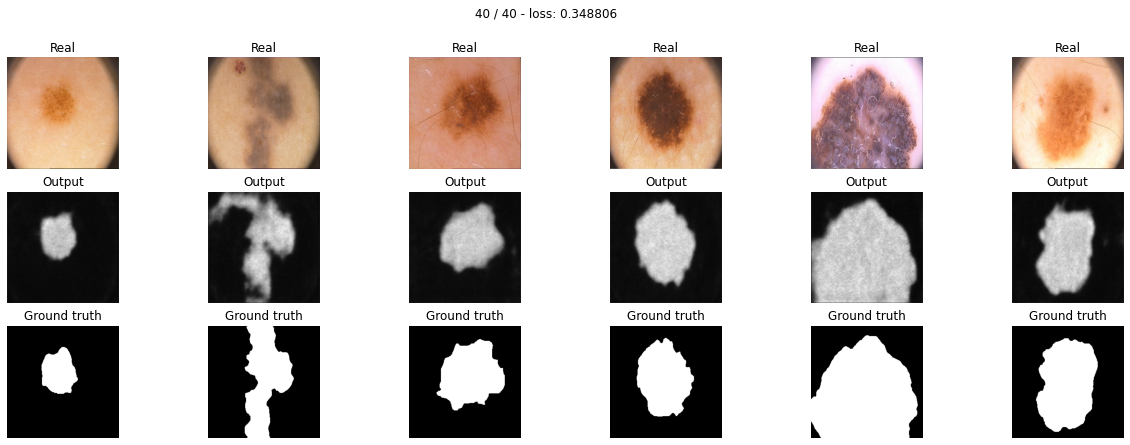

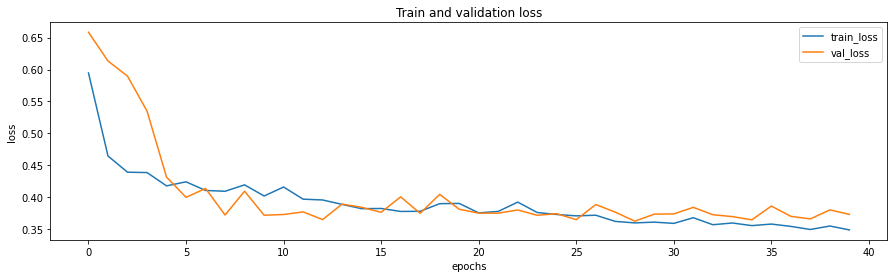

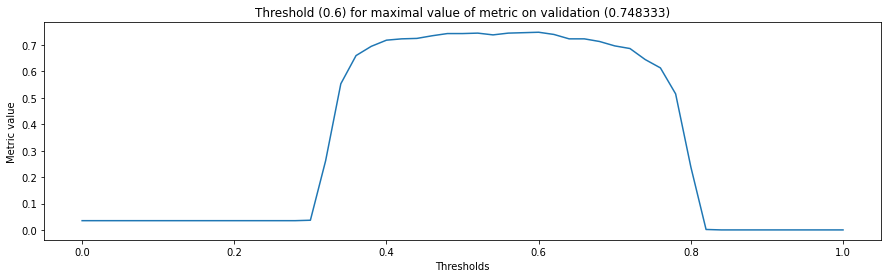

IoU on test = 0.7366666674613953


In [ ]:
model = SegNet().to(device)

max_epochs = 40
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
training_time = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(model, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(model, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(model)

# Save results
results_report.append(
    {"model": "SegNet", "Loss": "BCE", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
# # version 1.0 
# def dice_loss(y_real, y_pred):
#     SMOOTH = 1e-8
#     # obtain probabilities from logits
#     y_pred = F.sigmoid(y_pred)       
#     # flatten label and prediction tensors (only arrangment is matter)
#     y_pred = y_pred.view(-1)
#     y_real = y_real.view(-1)
#     intersection = (y_pred * y_real).sum()
#     union = y_pred.sum() + y_real.sum()                         
#     res = (2.*intersection + SMOOTH) / (union + SMOOTH) 
#     return 1 - res


def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    # obtain probabilities from logits
    y_pred = F.sigmoid(y_pred)       
    # flatten each picture to the vector
    y_pred = y_pred.view(y_pred.shape[0], -1)
    y_real = y_real.view(y_real.shape[0], -1)
        
    res = 1 - ((2. * y_pred * y_real + SMOOTH) / (y_pred + y_real + SMOOTH)).mean(dim=-1)
    return res.mean()

Проводим тестирование:

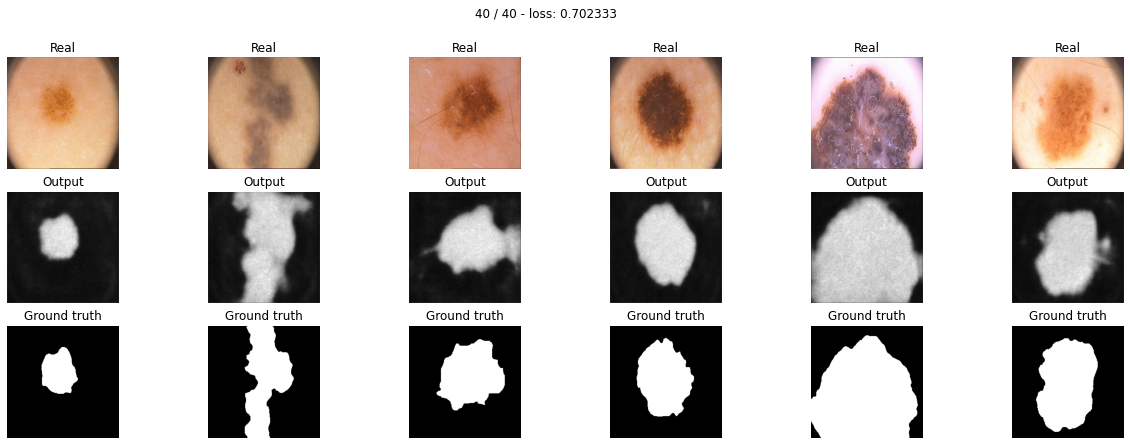

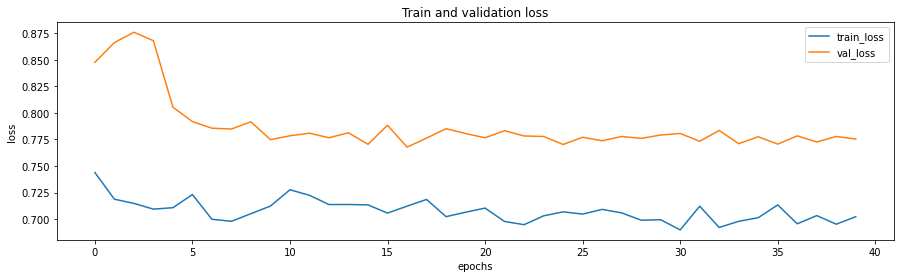

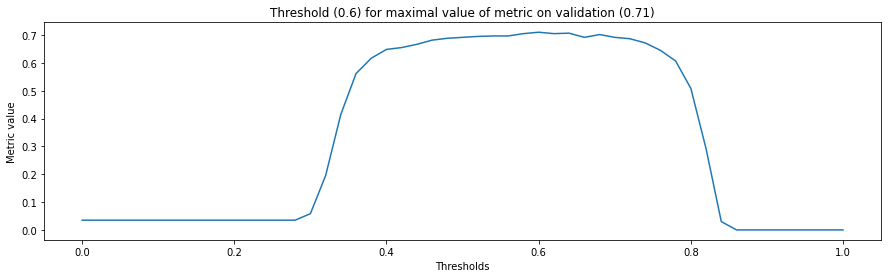

IoU on test = 0.7433333992958069


In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_dice.parameters(), lr=0.0001)
training_time = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(model_dice, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(model_dice, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(model)

# Save results
results_report.append(
    {"model": "SegNet", "Loss": "Dice", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-3, gamma = 2):
    # obtain probabilities from logits
    y_pred = F.sigmoid(y_pred)        
    #flatten label and prediction tensors
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    
    ## version 1.0
    # alpha = 0.8 
    # #first compute binary cross-entropy 
    # BCE = F.binary_cross_entropy(y_pred, y_real, reduction='mean')
    # BCE_EXP = torch.exp(-BCE)
    # focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE
    
    # ## version 2.0    
    y_pred = torch.clamp(y_pred, min=eps, max=(1-eps))
    term1 = (1 - y_pred)**gamma * y_real * torch.log(y_pred)
    term2 = (1 - y_real) * torch.log(1 - y_pred)
    focal_loss = - (term1 + term2).mean()
    
    return focal_loss

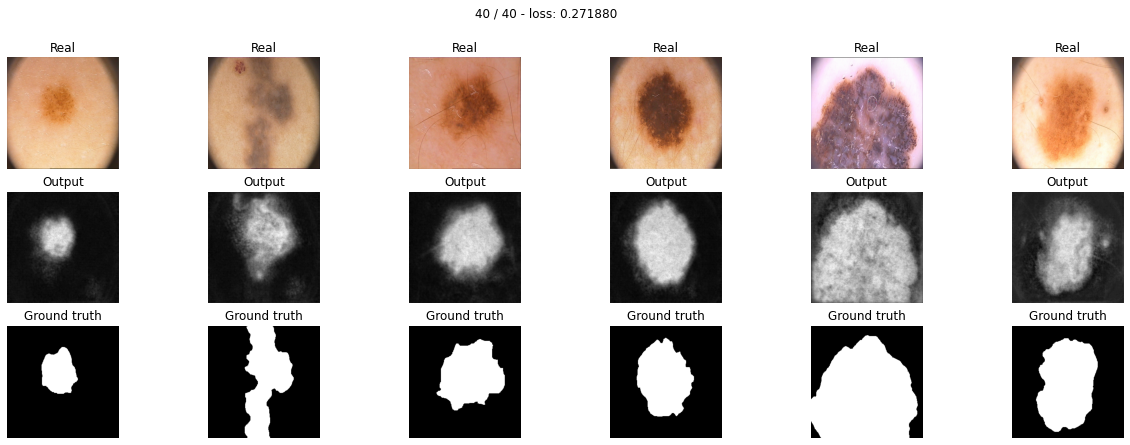

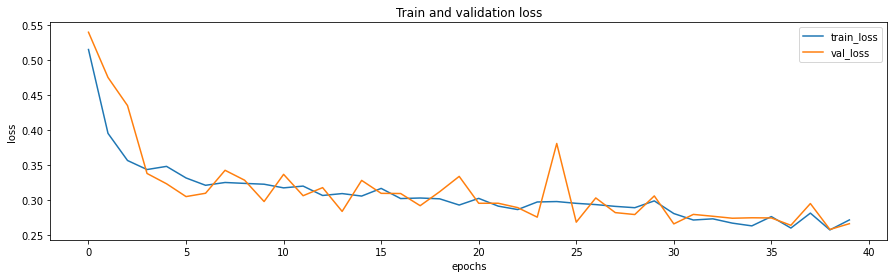

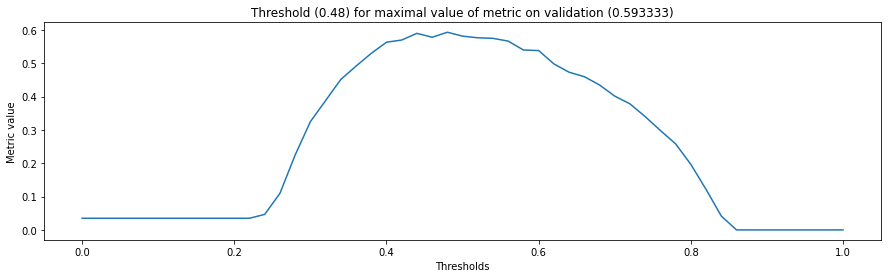

IoU on test = 0.6766666889190673


In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_focal.parameters(), lr=0.0005)
training_time = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(model_focal, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(model_focal, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(model)

# Save results
results_report.append(
    {"model": "SegNet", "Loss": "Focal", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# <TODO>
# Выберем beta=0.8 чтобы сделать фокус на false negatives
def tversky_loss(y_real, y_pred, alpha=0.2, beta=0.8):
    SMOOTH = 1e-8
    # obtain probabilities from logits
    y_pred = F.sigmoid(y_pred)       
        
    #flatten label and prediction tensors
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
        
    #True Positives, False Positives & False Negatives
    TP = (y_pred * y_real).sum()    
    FP = ((1 - y_real) * y_pred).sum()
    FN = (y_real * (1 - y_pred)).sum()
       
    Tversky = (TP + SMOOTH) / (TP + alpha * FP + beta * FN + SMOOTH)  
        
    return 1 - Tversky

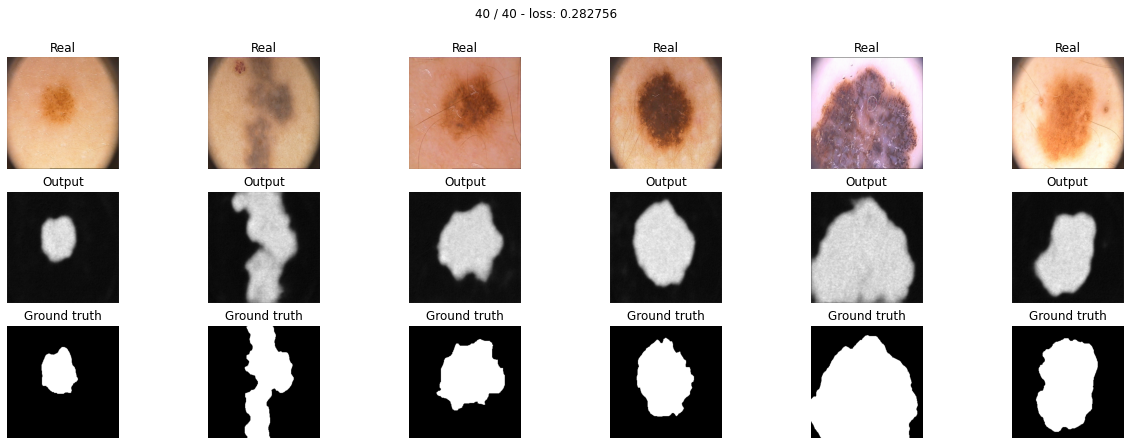

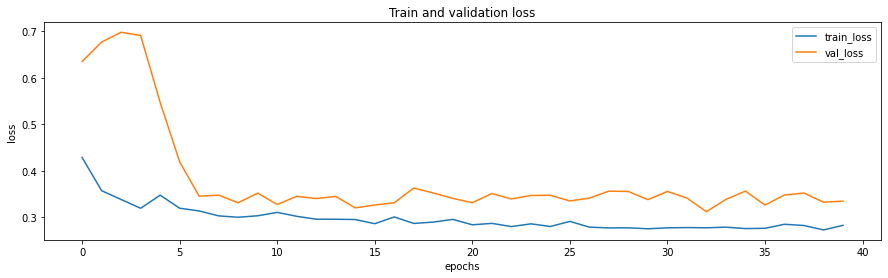

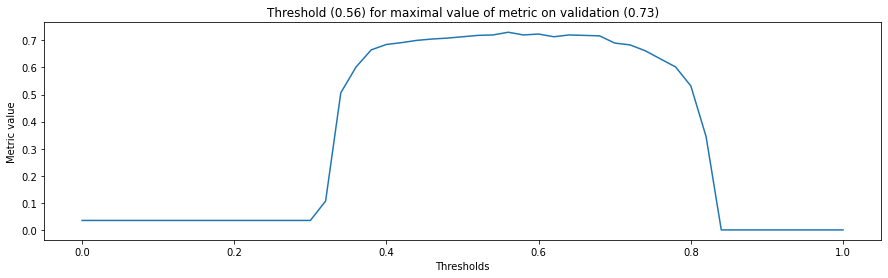

IoU on test = 0.7066666841506958


In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(model_tversky.parameters(), lr=0.0001)
training_time = train(model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(model_tversky, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(model_tversky, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(model)

# Save results
results_report.append(
    {"model": "SegNet", "Loss": "Tversky", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

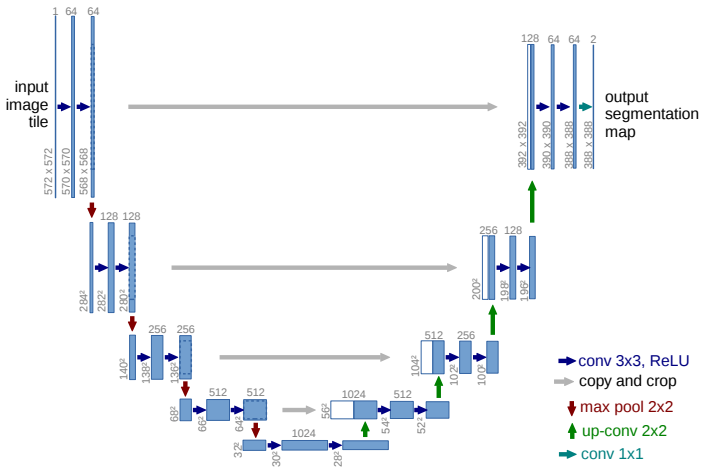

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self,
                 num_classes=1,
                 input_channels=3,
                 min_channels=32,
                 max_channels=512,
                 num_down_blocks=4):
        super(UNet, self).__init__()
        # Outline: input_ch -> min_ch -> 2*min_ch ->...-> max_ch -> ... 2*min_ch -> min_ch -> num_classes 
        self.num_classes = num_classes
        self.min_channels = min_channels       
        self.max_channels = max_channels       # number of channels in bottleneck
        self.num_down_blocks = num_down_blocks # number of downsaple/upsample blocks

        # 0. Zero_layer maps channels of the input image to
        # the minimum number of channels in downsampling block.
        self.zero_layer = nn.Conv2d(input_channels, min_channels, kernel_size=1, stride=1, padding=0)
        
        # 1. Downsampling
        # Each downsampling block doubles the number of channels starting from min_channels if possible
        # (curent_num_channels * 2 <= max.channels), else it does not change the number of channels.
        
        # Lists `in_channels_down`/`out_channels_down` contain number of in/out channels in each block
        in_channels_down = np.zeros(self.num_down_blocks + 1, dtype=np.int)
        out_channels_down = np.zeros(self.num_down_blocks + 1, dtype=np.int)
        in_channels_down[1] = self.min_channels # The first layer always has n_in = min_channels
        out_channels_down[1] = self.min_channels * 2
        
        for i in range(2, self.num_down_blocks + 1):
            in_channels_down[i] = out_channels_down[i - 1]
            if 2 * in_channels_down[i] <= self.max_channels:
                out_channels_down[i] = 2 * in_channels_down[i]
            else:
                out_channels_down[i] = in_channels_down[i]
        out_channels_down[-1] = self.max_channels # The last layer always has n_out = max_channels
        
        # Adding all (num_down_blocks) downsampling blocks (the first one is `the closest` to the input image).
        for i in range(1, num_down_blocks + 1):
            n_in = in_channels_down[i]
            n_out = out_channels_down[i]
            block = nn.Sequential(
                    nn.Conv2d(n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(n_out),
                    nn.ReLU(inplace=False),
                    nn.Conv2d(n_out, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(n_out),
                    nn.ReLU(inplace=False),
                )
            setattr(self, "downsampling" + str(i), block)

            max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  # MAXPOOL FOR DOWNSAMPLING
            setattr(self, "downsampling_maxpool" + str(i), max_pool)
            
            
        # 2. Bottleneck
        # Adding the bottleneck.
        self.bottleneck = nn.Sequential(
            nn.Conv2d(self.max_channels, self.max_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.max_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(self.max_channels, self.max_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.max_channels),
            nn.ReLU(inplace=False),
        )

                
        # 3. Upsampling
        # Adding several (num_down_blocks) upsampling blocks (the first one is `the closest` to the output image).
        for i in range(num_down_blocks, 0, -1):
            n_in = out_channels_down[i]
            n_out = in_channels_down[i]
            upsample = nn.Upsample(scale_factor=2, mode='nearest') # NEAREST NEIGHBOURING UPSAMPLING
            setattr(self, "upsampling_nearest" + str(i), upsample)
    
            block = nn.Sequential(
                nn.Dropout2d(p=0.5, inplace=True),
                nn.Conv2d(out_channels_down[i] + n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(n_out),
                nn.ReLU(inplace=False),
                nn.Conv2d(n_out, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(n_out),
                nn.ReLU(inplace=False),
            )
            setattr(self, "upsampling" + str(i), block)

        # 4. Conv 1x1
        # Last_layer
        self.last_layer = nn.Sequential(
            nn.Conv2d(self.min_channels, self.num_classes, kernel_size=1, stride=1, padding=0, bias=True),
        )

    ############################################################################## 
    def forward(self, inputs):

        # Finding the nearest size (h,w) which is divided by 2**num_down_blocks:
        new_input_width = self.find_nearest_size(inputs.shape[-1])
        new_input_height = self.find_nearest_size(inputs.shape[-2])

        # Interpolate inputs to the new size:
        if inputs.shape[-1] != new_input_width or inputs.shape[-2] != new_input_height:
            x = F.interpolate(inputs, size=(new_input_height, new_input_width), mode='bilinear', align_corners=False)
        else:
            x = inputs
            

        # 0. Mapping in_channels=3 -> self.min_channels
        x = self.zero_layer(x)

        # 1. Downsampling
        downsampling_outputs = {}
        for i in range(1, self.num_down_blocks + 1):
            # Go through downsampling block and save the result (will be used in upsampling block
            downsampling = getattr(self, "downsampling" + str(i))
            x = downsampling(x)
            downsampling_outputs[str(i)] = torch.clone(x)

            # Go through MAXPOOL FOR DOWNSAMPLING
            x = getattr(self, "downsampling_maxpool" + str(i))(x)

        # 2. Bottleneck
        x = self.bottleneck(x)
        
        

        # 3. Upsampling
        for i in range(self.num_down_blocks, 0, -1):
            # Go through NEAREST NEIGHBOURING UPSAMPLING
            x = getattr(self, "upsampling_nearest" + str(i))(x)

            # Concatenate the result and the tensor saved during downsampling block
            x = torch.cat((x, downsampling_outputs[str(i)]), dim=1)

            # Go through upsampling block
            x = getattr(self, "upsampling" + str(i))(x)

            
        # 4. Conv 1x1
        logits = self.last_layer(x)

        # Interpolate logits back to the original size (if needed):
        if inputs.shape[-1] != new_input_width or inputs.shape[-2] != new_input_height:
            logits = F.interpolate(logits, size=(inputs.shape[-2], inputs.shape[-1]), mode='bilinear', align_corners=False)

        assert logits.shape == (
        inputs.shape[0], self.num_classes, inputs.shape[2], inputs.shape[3]), 'Wrong shape of the logits'
        return logits

    ############################################################################## 
    def find_nearest_size(self, input_size):
        p = 2 ** self.num_down_blocks
        k = 1
        while input_size > k * p:
            k += 1
        if abs(k * p - input_size) <= abs((k - 1) * p - input_size):
            return k * p
        else:
            return (k - 1) * p

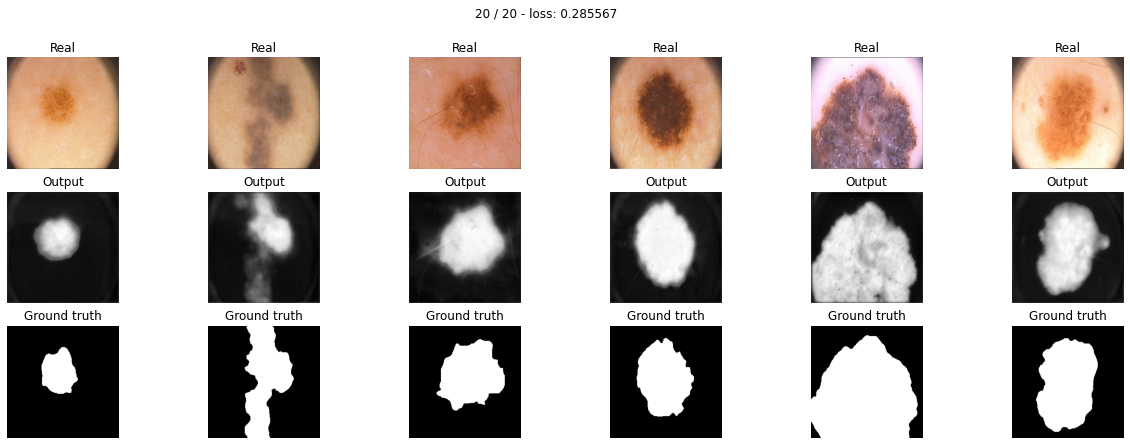

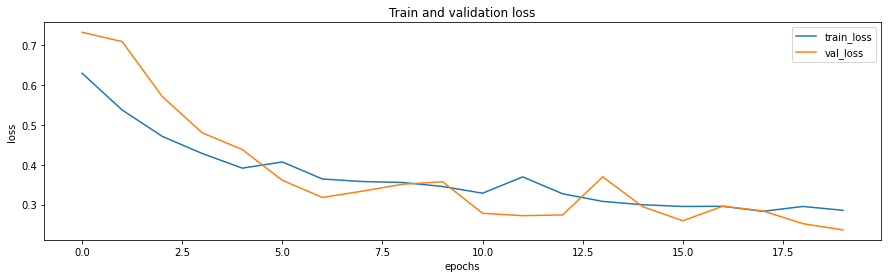

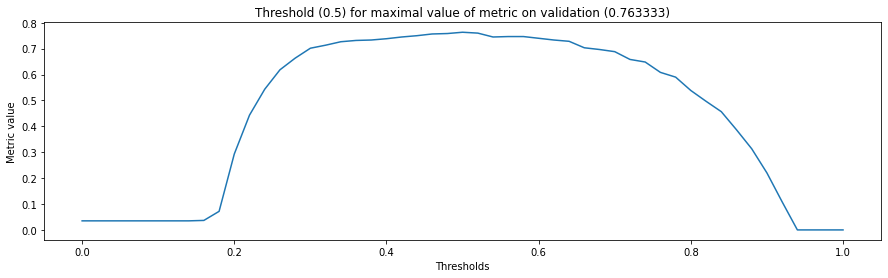

IoU on test = 0.7600000262260437


In [ ]:
unet_model = UNet().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.0001)
training_time = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet_model, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet_model, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet_model)

# Save results
results_report.append(
    {"model": "UNet", "Loss": "BCE", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

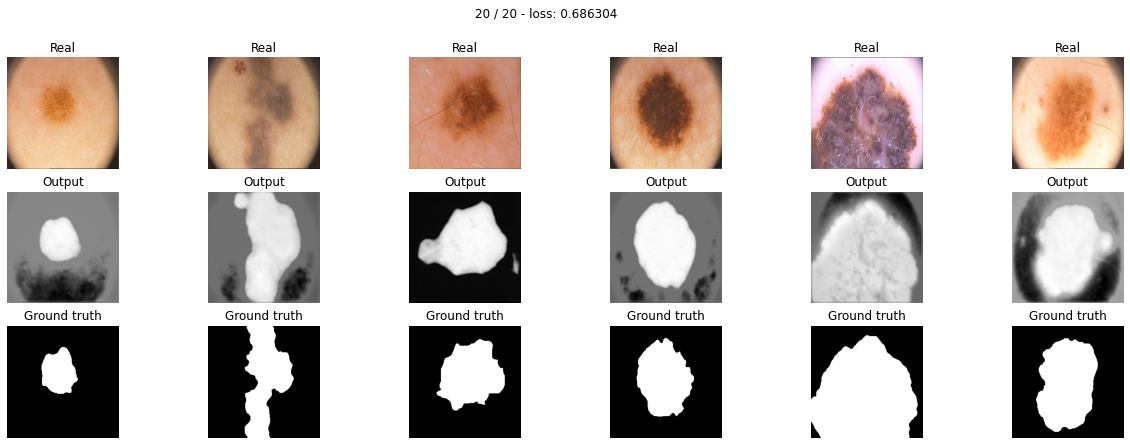

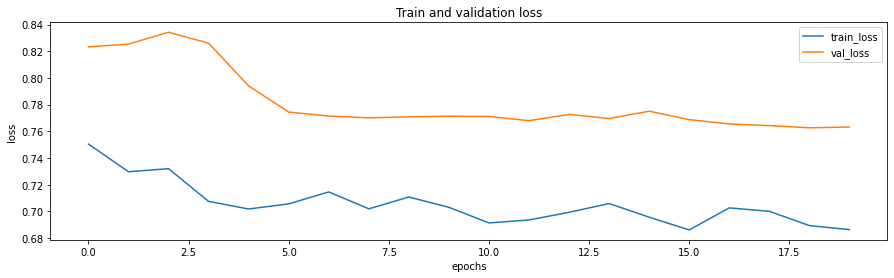

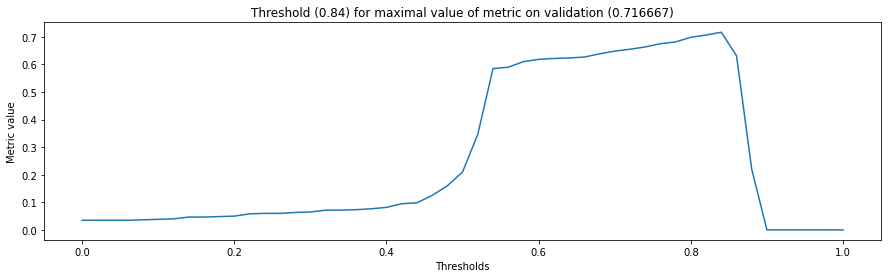

IoU on test = 0.7166666865348816


In [ ]:
############### UNET + DICE 
unet_model_dice = UNet().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet_model_dice.parameters(), lr=0.0001)
training_time = train(unet_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet_model_dice, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet_model_dice, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet_model_dice)

# Save results
results_report.append(
    {"model": "UNet", "Loss": "Dice", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

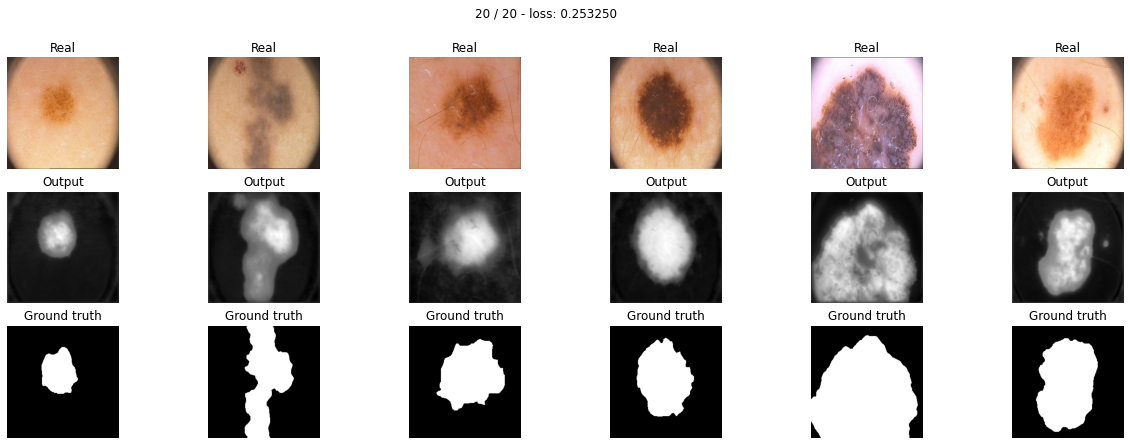

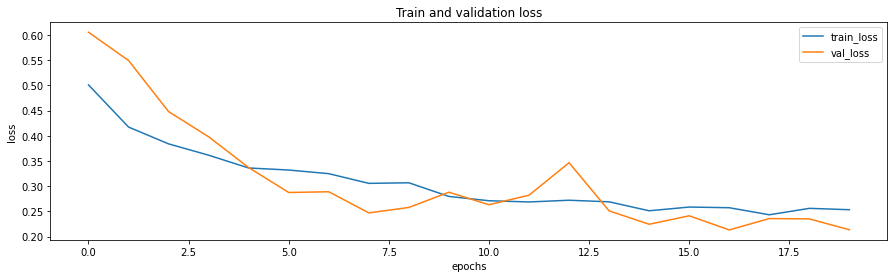

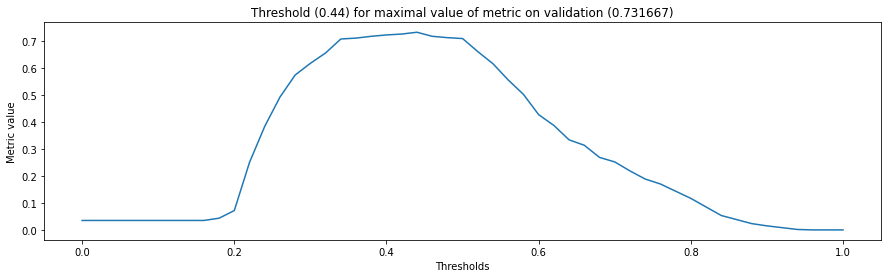

IoU on test = 0.6850000262260437


In [ ]:
############### UNET + FOCAL
unet_model_focal = UNet().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet_model_focal.parameters(), lr=0.0001)
training_time = train(unet_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet_model_focal, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet_model_focal, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet_model_focal)

# Save results
results_report.append(
    {"model": "UNet", "Loss": "Focal", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

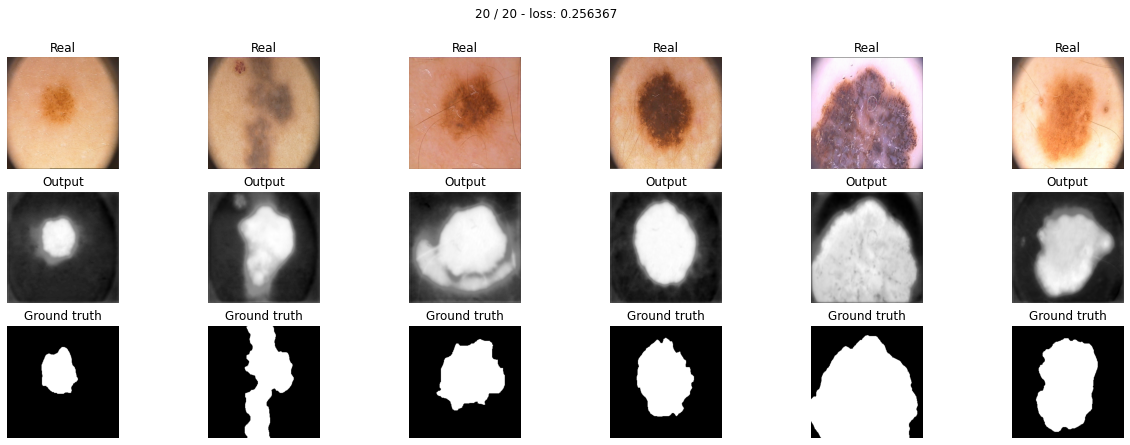

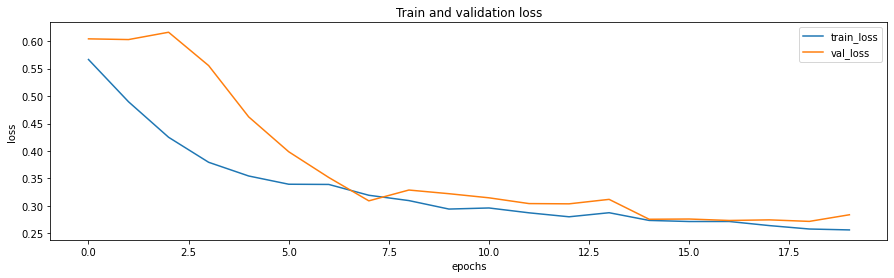

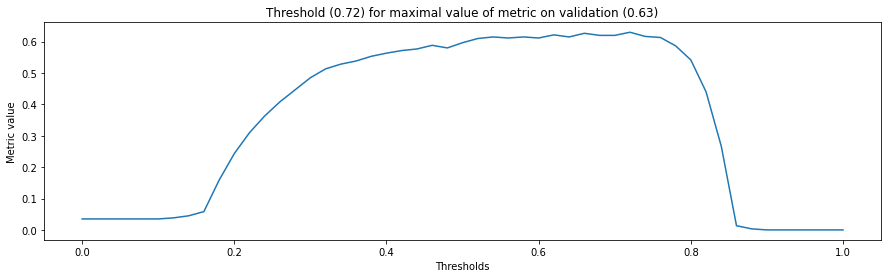

IoU on test = 0.6533333659172058


In [ ]:
############### UNET + TVERSKY
unet_model_tversky = UNet().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet_model_tversky.parameters(), lr=0.0001)
training_time = train(unet_model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet_model_tversky, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet_model_tversky, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet_model_tversky)

# Save results
results_report.append(
    {"model": "UNet", "Loss": "Tversky", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self,
                 num_classes=1,
                 input_channels=3,
                 min_channels=32,
                 max_channels=512,
                 num_down_blocks=4):
        super(UNet2, self).__init__()
        # Outline: input_ch -> min_ch -> 2*min_ch ->...-> max_ch -> ... 2*min_ch -> min_ch -> num_classes 
        self.num_classes = num_classes
        self.min_channels = min_channels       
        self.max_channels = max_channels       # number of channels in bottleneck
        self.num_down_blocks = num_down_blocks # number of downsaple/upsample blocks

        # 0. Zero_layer maps channels of the input image to
        # the minimum number of channels in downsampling block.
        self.zero_layer = nn.Conv2d(input_channels, min_channels, kernel_size=1, stride=1, padding=0)
        
        # 1. Downsampling
        # Each downsampling block doubles the number of channels starting from min_channels if possible
        # (curent_num_channels * 2 <= max.channels), else it does not change the number of channels.
        
        # Lists `in_channels_down`/`out_channels_down` contain number of in/out channels in each block
        in_channels_down = np.zeros(self.num_down_blocks + 1, dtype=np.int)
        out_channels_down = np.zeros(self.num_down_blocks + 1, dtype=np.int)
        in_channels_down[1] = self.min_channels # The first layer always has n_in = min_channels
        out_channels_down[1] = self.min_channels * 2
        
        for i in range(2, self.num_down_blocks + 1):
            in_channels_down[i] = out_channels_down[i - 1]
            if 2 * in_channels_down[i] <= self.max_channels:
                out_channels_down[i] = 2 * in_channels_down[i]
            else:
                out_channels_down[i] = in_channels_down[i]
        out_channels_down[-1] = self.max_channels # The last layer always has n_out = max_channels
        
        # Adding all (num_down_blocks) downsampling blocks (the first one is `the closest` to the input image).
        for i in range(1, num_down_blocks + 1):
            n_in = in_channels_down[i]
            n_out = out_channels_down[i]
            block = nn.Sequential(
                    nn.Conv2d(n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(n_out),
                    nn.ReLU(inplace=False),
                    nn.Conv2d(n_out, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                    nn.BatchNorm2d(n_out),
                    nn.ReLU(inplace=False),
                )
            setattr(self, "downsampling" + str(i), block)

            # CONVOLUTION WITH STRIDE=2 FOR DOWNSAMPLING
            conv_stride = nn.Conv2d(n_out, n_out, kernel_size=4, stride=2, padding=1)  
            setattr(self, "downsampling_conv_stride" + str(i), conv_stride)
            
            
        # 2. Bottleneck
        # Adding the bottleneck.
        self.bottleneck = nn.Sequential(
            nn.Conv2d(self.max_channels, self.max_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.max_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(self.max_channels, self.max_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.max_channels),
            nn.ReLU(inplace=False),
        )

                
        # 3. Upsampling
        # Adding several (num_down_blocks) upsampling blocks (the first one is `the closest` to the output image).
        for i in range(num_down_blocks, 0, -1):
            n_in = out_channels_down[i]
            n_out = in_channels_down[i]
            
            # TRANSPOSED CONVOLUTION FOR UPSAMPLING
            conv_transpose = nn.ConvTranspose2d(n_in, n_in, kernel_size=3, stride=2, padding=1, output_padding=1)
            setattr(self, "upsampling_conv" + str(i), conv_transpose)
    
            block = nn.Sequential(
                nn.Dropout2d(p=0.5, inplace=True),
                nn.Conv2d(out_channels_down[i] + n_in, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(n_out),
                nn.ReLU(inplace=False),
                nn.Conv2d(n_out, n_out, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(n_out),
                nn.ReLU(inplace=False),
            )
            setattr(self, "upsampling" + str(i), block)

        # 4. Conv 1x1
        # Last_layer
        self.last_layer = nn.Sequential(
            nn.Conv2d(self.min_channels, self.num_classes, kernel_size=1, stride=1, padding=0, bias=True),
        )

    ############################################################################## 
    def forward(self, inputs):

        # Finding the nearest size which is divided by 2**num_down_blocks:
        new_input_width = self.find_nearest_size(inputs.shape[-1])
        new_input_height = self.find_nearest_size(inputs.shape[-2])

        # Interpolate inputs to the new size:
        if inputs.shape[-1] != new_input_width or inputs.shape[-2] != new_input_height:
            x = F.interpolate(inputs, size=(new_input_height, new_input_width), mode='bilinear', align_corners=False)
        else:
            x = inputs

        # 0. Mapping 3 -> self.min_channels
        x = self.zero_layer(x)

        # 1. Downsampling
        downsampling_outputs = {}
        for i in range(1, self.num_down_blocks + 1):
            # Go through downsampling block and save the result (will be used in upsampling block
            downsampling = getattr(self, "downsampling" + str(i))
            x = downsampling(x)
            downsampling_outputs[str(i)] = torch.clone(x)

            # Go through CONVOLUTION WITH STRIDE=2 FOR DOWNSAMPLING
            x = getattr(self, "downsampling_conv_stride" + str(i))(x) 

        # 2. Bottleneck
        x = self.bottleneck(x)

        # 3. Upsampling
        for i in range(self.num_down_blocks, 0, -1):
            # Go through conv transpose
            x = getattr(self, "upsampling_conv" + str(i))(x)

            # Concatenate the result and the tensor saved during downsampling block
            x = torch.cat((x, downsampling_outputs[str(i)]), dim=1)

            # Go through TRANSPOSED CONVOLUTION FOR UPSAMPLING
            x = getattr(self, "upsampling" + str(i))(x)

        # 4. Conv 1x1
        logits = self.last_layer(x)

        # Interpolate logits back to the original size (if needed):
        if inputs.shape[-1] != new_input_width or inputs.shape[-2] != new_input_height:
            logits = F.interpolate(logits, size=(inputs.shape[-2], inputs.shape[-1]), mode='bilinear', align_corners=False)

        assert logits.shape == (
        inputs.shape[0], self.num_classes, inputs.shape[2], inputs.shape[3]), 'Wrong shape of the logits'
        return logits

    ############################################################################## 
    def find_nearest_size(self, input_size):
        p = 2 ** self.num_down_blocks
        k = 1
        while input_size > k * p:
            k += 1
        if abs(k * p - input_size) <= abs((k - 1) * p - input_size):
            return k * p
        else:
            return (k - 1) * p

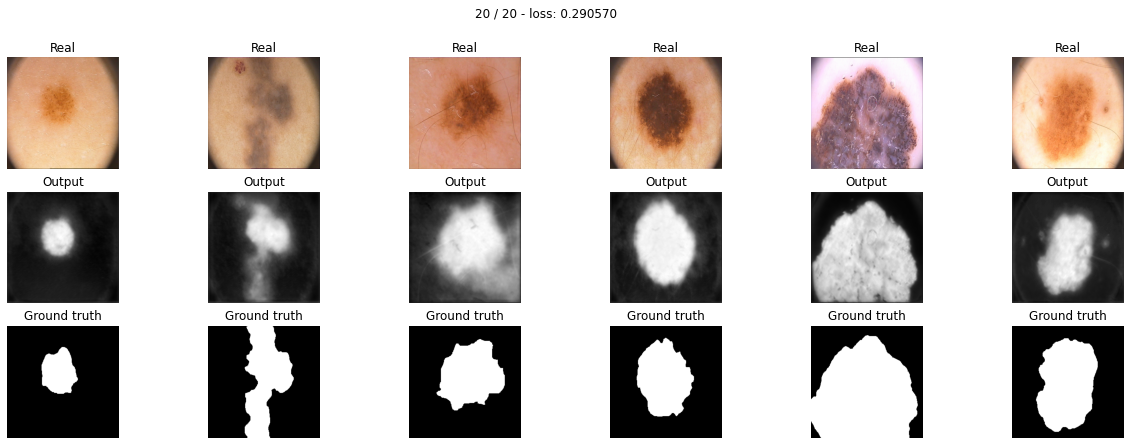

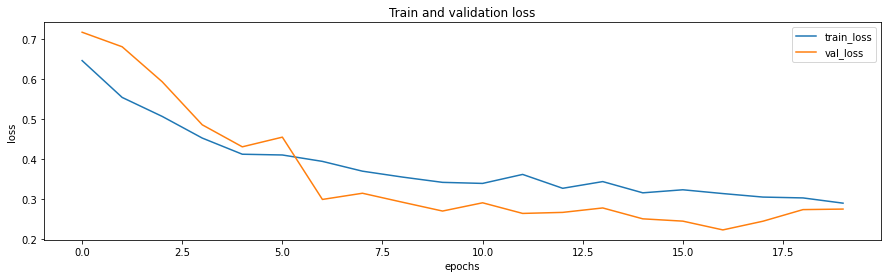

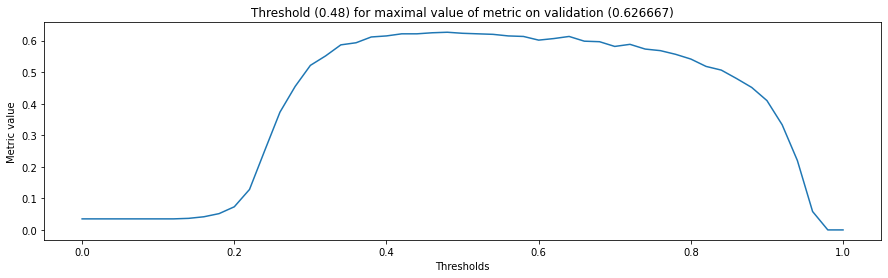

IoU on test = 0.6116667032241822


In [ ]:
unet2_model = UNet2().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet2_model.parameters(), lr=0.0001)
training_time = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet2_model, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet2_model, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet2_model)

# Save results
results_report.append(
    {"model": "UNet2", "Loss": "BCE", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

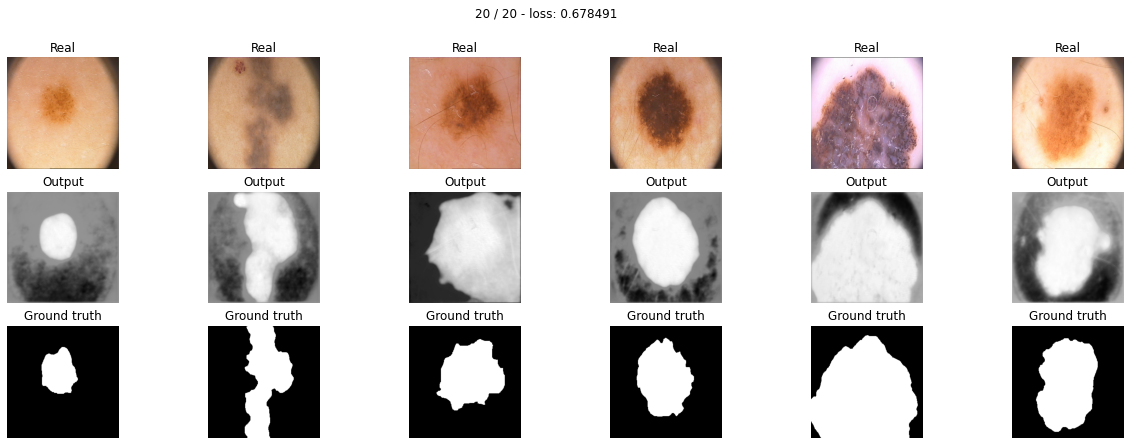

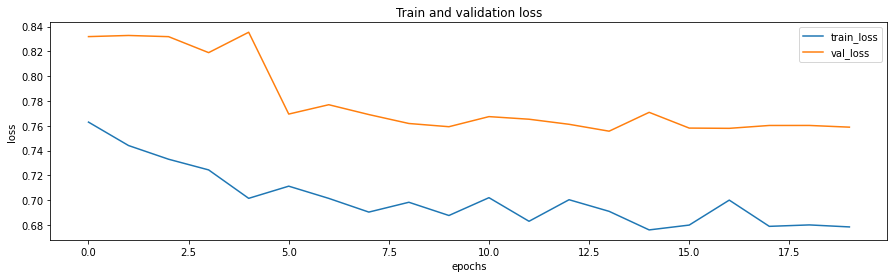

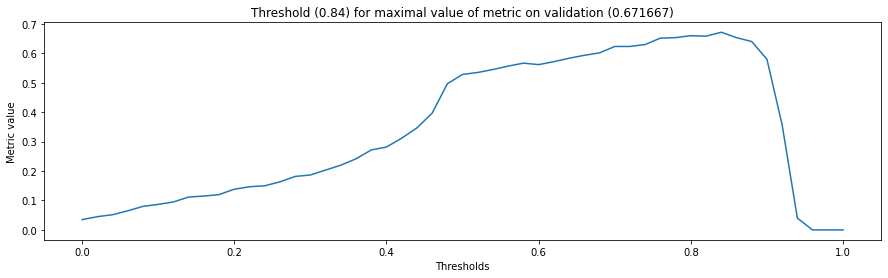

IoU on test = 0.6000000357627868


In [ ]:
############### UNET2 + DICE 
unet2_model_dice = UNet2().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet2_model_dice.parameters(), lr=0.0001)
training_time = train(unet2_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet2_model_dice, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet2_model_dice, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet2_model_dice)

# Save results
results_report.append(
    {"model": "UNet2", "Loss": "Dice", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

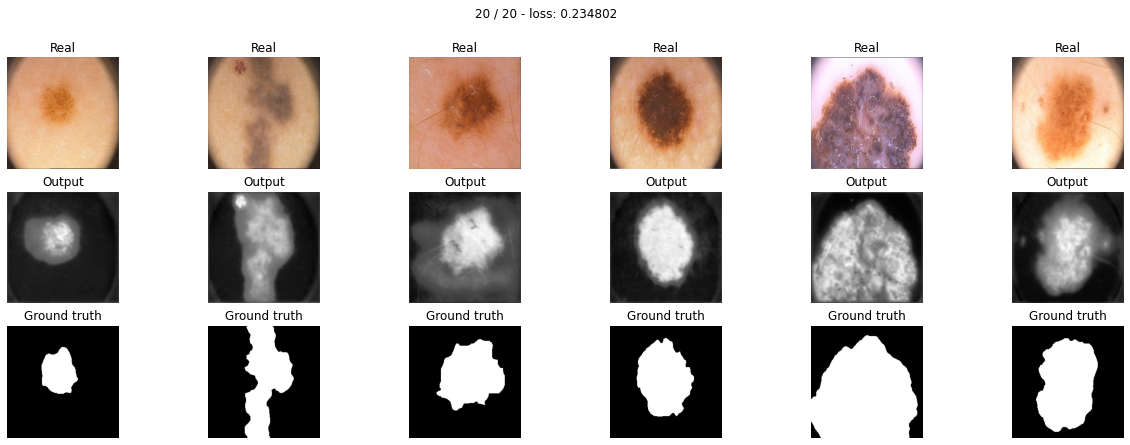

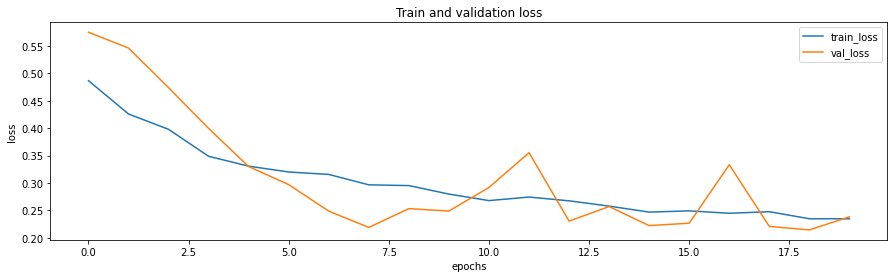

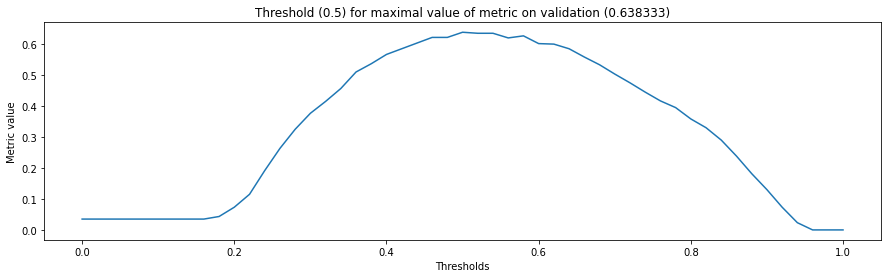

IoU on test = 0.5633333563804627


In [ ]:
############### UNET2 + FOCAL
unet2_model_focal = UNet2().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet2_model_focal.parameters(), lr=0.0001)
training_time = train(unet2_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet2_model_focal, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet2_model_focal, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet2_model_focal)

# Save results
results_report.append(
    {"model": "UNet2", "Loss": "Focal", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

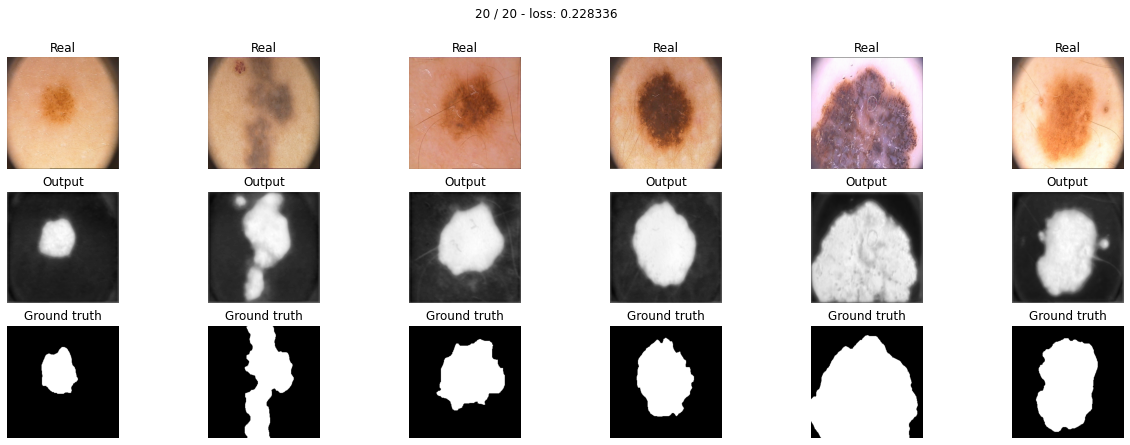

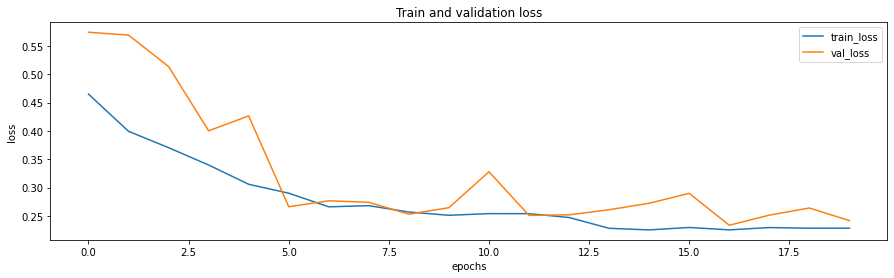

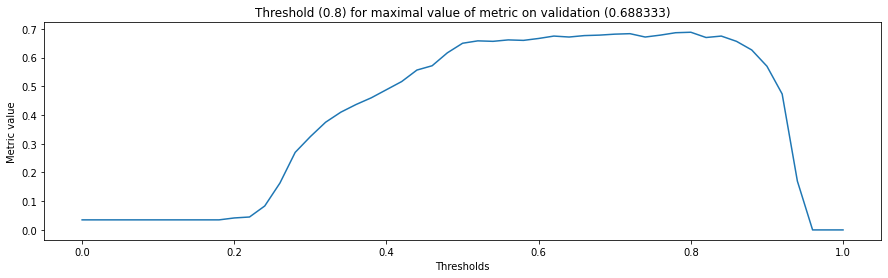

IoU on test = 0.6483333706855774


In [ ]:
############### UNET2 + TVERSKY
unet2_model_tversky = UNet2().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet2_model_tversky.parameters(), lr=0.0001)
training_time = train(unet2_model_tversky, optimizer, tversky_loss, max_epochs, data_tr, data_val)

# Obtain threshold for iou_pytorch metric
threshold, metric_val = plot_thresholds(unet2_model_tversky, iou_pytorch, data_val)

# Score on test with obtained on validation threshold for iou_pytorch metric
metric_test = score_model(unet2_model_tversky, iou_pytorch, data_ts, threshold=threshold)
print(f'IoU on test = {metric_test}')

# Cals inference_time
inference_time = calc_inference_time(unet2_model_tversky)

# Save results
results_report.append(
    {"model": "UNet2", "Loss": "Tversky", 
     "IoU_val": metric_val, "IoU_test": metric_test,
     "Inference time, ms": inference_time, "Training time, min": training_time}
)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

## Отчёт

Графики лоссов на валидации и трейне выводились выше, в момент обучения. 

После обучения каждой модели проводилось вычисление метрики на тесте. Но поскольку значение целевой метрики IoU зависит ещё и от порогового значения вероятности, по которому мы отсекаем метку 1-го класса, нам нужно было определить наилучшее значение этого порога. Для этого на валидационной части оценивалось значение целевой метрики для разных значений порога и выбиралось то значение, которое доставляет максимальное значение IoU. В процессе также выводился график. Затем с этим значением порога высчитывалось значение метрики на тестовой части.

Кроме того, во время трейна измерялось также время обучения (в минутах), а после трейна - инференс-время (в мс). Инференс время рассчитывалось как среднее время для предсказания модели на рандомном тензоре размера `[1, 3, 256, 256]`.

Рассмотрим полученные значения подробно.


In [ ]:
table = pd.DataFrame(results_report)

# Добавим цвета и маркеры
table.loc[table.model == 'SegNet', 'colors'] = 'red'
table.loc[table.model == 'UNet', 'colors'] = 'blue'
table.loc[table.model == 'UNet2', 'colors'] = 'green'

table.loc[table.Loss == 'BCE', 'markers'] = 'o'
table.loc[table.Loss == 'Dice', 'markers'] = 's'
table.loc[table.Loss == 'Focal', 'markers'] = '>'
table.loc[table.Loss == 'Tversky', 'markers'] = '^'

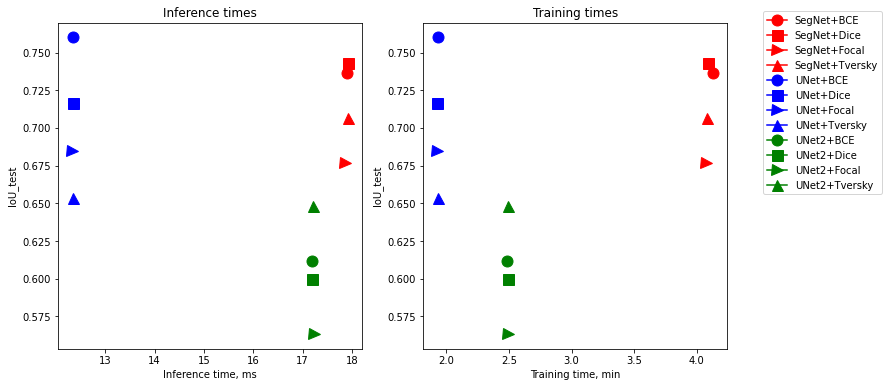

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))

for i, marker in enumerate(table.markers):
    ax1.plot(table['Inference time, ms'][i], 
             table['IoU_test'][i], 
             marker=table.markers[i], 
             color=table.colors[i], 
             markersize=11,
             label=table.model[i] + '+' + table.Loss[i])
ax1.set(xlabel='Inference time, ms', ylabel='IoU_test', title='Inference times')

for i, marker in enumerate(table.markers):
    ax2.plot(table['Training time, min'][i], 
             table['IoU_test'][i], 
             marker=table.markers[i], 
             color=table.colors[i], 
             markersize=11,
             label=table.model[i] + '+' + table.Loss[i])
ax2.set(xlabel='Training time, min', ylabel='IoU_test', title='Training times')
    
ax2.legend(bbox_to_anchor=(1.1, 1.05));

Как мы видим, самая лучшая метрика IoU получается у модели SegNet+BCE, однако она дольше всех обучалась (40 эпох вместо 20). При этом UNet+Tversky, хоть и даёт чуть хуже метрику IoU, но зато гораздо быстрее обучается и быстрее делает предсказания. Модель UNet2 оказалась самой медленной и не очень эффективной.

Таким образом, если нам важна скорость предсказаний, и мы можем немного пожертвовать качеством, то наш выбор UNet+Tversky. Если же у нас в приоритете качество, то наш выбор - SegNet+BCE.

Если же сравнивать между собой функции потерь, то в пределах одной модели BCE loss и Tversky loss дают одни из лучших значений метрик.


Давайте теперь визуализируем сегментационные результаты для трёх моделей с их лучшими метриками: SegNet+BCE, UNet+Tversky, UNet2+BCE.


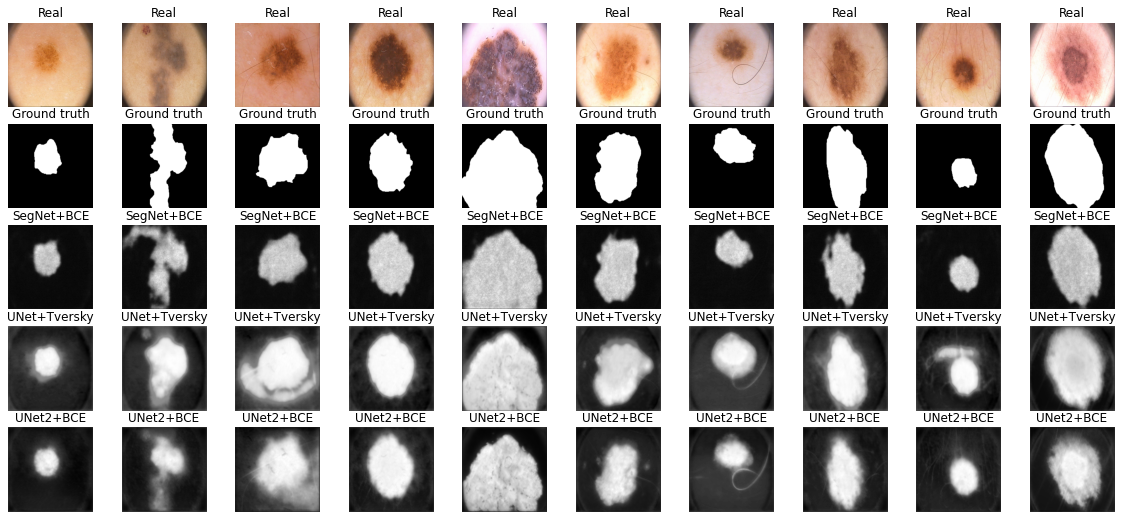

In [ ]:
# list_of_models = [model, model_dice, model_focal, model_tversky,
#                   unet_model, unet_model_dice, unet_model_focal, unet_model_tversky,
#                   unet2_model, unet2_model_dice, unet2_model_focal, unet2_model_tversky,
#                   ]

# Models for visualization
list_of_models = [model, unet_model_tversky, unet2_model]
list_of_names = ['SegNet+BCE', 'UNet+Tversky', 'UNet2+BCE']
X_val, Y_val = next(iter(data_val))

# Hyperparameters
NUM_OF_PICTURES = 10
HEIGHT = 3
WIDTH = 2
n_models = len(list_of_models)
fig, axs = plt.subplots(n_models + 2, NUM_OF_PICTURES, 
                        figsize=(NUM_OF_PICTURES*WIDTH, n_models*HEIGHT))

# Real images
for k in range(NUM_OF_PICTURES):
    axs[0, k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    axs[0, k].set_title('Real')
    axs[0, k].axis('off')

# Ground truth masks
for k in range(NUM_OF_PICTURES):
    axs[1, k].imshow(Y_val[k, 0].numpy(), cmap='gray')
    axs[1, k].set_title('Ground truth')
    axs[1, k].axis('off')

# Model's predictions
for i, current_model in enumerate(list_of_models):
    current_model.eval()  # testing mode
    Y_hat = current_model(X_val.cuda()).detach().cpu() # detach and put into cpu
    for k in range(NUM_OF_PICTURES):
        axs[i+2, k].imshow(Y_hat[k, 0], cmap='gray')
        axs[i+2, k].set_title(list_of_names[i])
        axs[i+2, k].axis('off')

Из предсказаний видно, что SegNet+BCE даёт более резкие и детализированные предсказания, нежели UNet+Tversky и UNet2+BCE. Модели UNet и UNet2 склонны предсказывать более размытые области, без сложных границ. Кроме того, модель UNet2 склонна ложно интерпретировать тонкие линии с резким изменением контраста как целевой класс.